In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
from bernoullimix import BernoulliMixture, random_mixture_generator

In [3]:
K, D = 4, 5
TRUE_PI = np.array([0.5, 0.25, 0.15, 0.1])
TRUE_P = np.array([[0.9, 0.2, 0.3, 0.1, 0.83],
                   [0.8, 0.8, 0.2, 0.9, 0.4],
                   [0.1, 0.1, 0.9, 0.8, 0.2],
                   [0.1, 0.4, 0.5, 0.05, 0.04]])
RANDOM_STATE = 1207

In [4]:
true_mixture = BernoulliMixture(K, D, TRUE_PI, TRUE_P)

In [5]:
N_SAMPLES = 3000
N_SPLIT_HALF = N_SAMPLES // 2
N_FULL_HALF = N_SPLIT_HALF + N_SAMPLES % 2

FULL_HALF_MISSING_COLUMNS = np.array([False, True, False, True, False])

In [6]:
full_observations, true_components = true_mixture.sample(N_SAMPLES, random_state=RANDOM_STATE)

In [7]:
full_observations = pd.DataFrame(full_observations) # todo: it should already be df

In [8]:
missing_observations = full_observations.copy()
missing_observations.iloc[:N_SPLIT_HALF//2, :D//2] = None
missing_observations.iloc[N_SPLIT_HALF//2:N_SPLIT_HALF, D//2:] = None
missing_observations.iloc[N_SPLIT_HALF:, FULL_HALF_MISSING_COLUMNS] = None

In [9]:
missing_observations.tail()

,0,1,2,3,4
2995,1,NaN,0,NaN,1
2996,0,NaN,1,NaN,0
2997,1,NaN,0,NaN,0
2998,1,NaN,0,NaN,1
2999,1,NaN,0,NaN,0


In [10]:
missing_observations.isnull().apply(tuple, axis=1).value_counts()

(False, True, False, True, False)    1500
(True, True, False, False, False)     750
(False, False, True, True, True)      750
dtype: int64

In [11]:
N_MIXTURES_TO_FIT = 500

In [12]:
generator = random_mixture_generator(K, missing_observations, random_state=RANDOM_STATE)

In [13]:
import itertools
mixtures = list(itertools.islice(generator, N_MIXTURES_TO_FIT))

In [14]:
%%time
convergences = []
lls = []
for mixture in mixtures:
    ll, convergence = mixture.fit(missing_observations, iteration_limit=None, convergence_threshold=1e-3)
    convergences.append(convergence)
    lls.append(ll)

CPU times: user 52.1 s, sys: 211 ms, total: 52.3 s
Wall time: 52.6 s


In [15]:
lls = pd.Series(lls)

In [16]:
best_mixture = mixtures[lls.argmax()]

In [17]:
best_mixture.emission_probabilities

array([[ 0.21097523,  0.04297232,  0.735145  ,  0.64089456,  0.13556147],
       [ 0.93029528,  0.49853995,  0.03611029,  0.52288757,  0.35402056],
       [ 0.44608578,  0.84166209,  0.45243936,  0.22539602,  0.64869782],
       [ 0.99077411,  0.2633183 ,  0.30270574,  0.18840821,  0.9660768 ]])

In [18]:
answer_pis = pd.Series(best_mixture.mixing_coefficients)
answer_ems = pd.DataFrame(best_mixture.emission_probabilities, 
                          index=answer_pis.index, 
                          columns=missing_observations.columns)


In [19]:
answer_pis = answer_pis.sort_values(ascending=False)
answer_ems = answer_ems.loc[answer_pis.index]

/Users/saulius/.virtualenvs/scientific-py3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


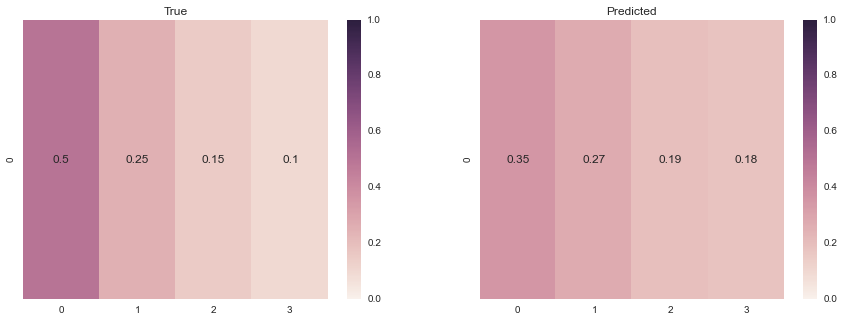

In [22]:
plt.figure(figsize=(15, 5))
ax = plt.subplot(1, 2, 1)
sns.heatmap(np.array([TRUE_PI]), annot=True, ax=ax, vmin=0, vmax=1)
plt.title('True')
ax = plt.subplot(1, 2, 2)
sns.heatmap(np.array([answer_pis]), annot=True, ax=ax, vmin=0, vmax=1)
plt.title('Predicted')

/Users/saulius/.virtualenvs/scientific-py3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


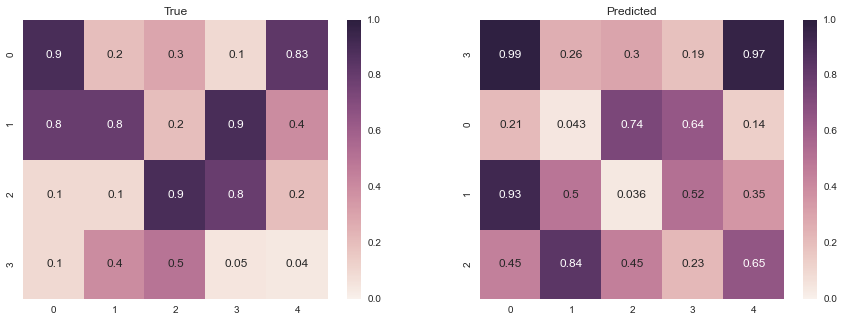

In [20]:
plt.figure(figsize=(15, 5))
ax = plt.subplot(1, 2, 1)
sns.heatmap(TRUE_P, annot=True, ax=ax, vmin=0, vmax=1)
plt.title('True')
ax = plt.subplot(1, 2, 2)
sns.heatmap(answer_ems, annot=True, ax=ax, vmin=0, vmax=1)
plt.title('Predicted')